# 1 初始化

## 1.1 导入包

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from tqdm import tqdm
import logging

log_fmt = "[%(asctime)s] %(levelname)s in %(module)s: %(message)s"
logging.basicConfig(format=log_fmt, level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

## 1.2 超参数定义

In [3]:
base_path = '/home/zengrui/datasets/190829_Kanshan_zjfx'

## 1.3 函数定义

In [3]:
def extract_day(s):
    return s.apply(lambda x: int(x.split('-')[0][1:]))


def extract_hour(s):
    return s.apply(lambda x: int(x.split('-')[1][1:]))

# 2 加载、处理数据

## 2.1 加载邀请回答数据

In [4]:
train = pd.read_csv(f'{base_path}/invite_info_0926.txt', sep='\t', header=None)
train.columns = ['qid', 'uid', 'dt', 'label']
logging.info("invite %s", train.shape)

test = pd.read_csv(f'{base_path}/invite_info_evaluate_1_0926.txt', sep='\t', header=None)
test.columns = ['qid', 'uid', 'dt']
logging.info("test %s", test.shape)

sub = test.copy()

sub_size = len(sub)

train['day'] = extract_day(train['dt'])
train['hour'] = extract_hour(train['dt'])

test['day'] = extract_day(test['dt'])
test['hour'] = extract_hour(test['dt'])

del train['dt'], test['dt']

[2019-12-06 21:38:54,672] INFO in <ipython-input-4-7a2c6478cb9e>: invite (9489162, 4)
[2019-12-06 21:38:56,030] INFO in <ipython-input-4-7a2c6478cb9e>: test (1141683, 3)


## 2.2 加载问题

丢弃了**问题info**的字词编码。

In [5]:
ques = pd.read_csv(f'{base_path}/question_info_0926.txt', header=None, sep='\t')
ques.columns = ['qid', 'q_dt', 'title_t1', 'title_t2', 'desc_t1', 'desc_t2', 'topic']
del ques['title_t1'], ques['title_t2'], ques['desc_t1'], ques['desc_t2']
logging.info("ques %s", ques.shape)

ques['q_day'] = extract_day(ques['q_dt'])
ques['q_hour'] = extract_hour(ques['q_dt'])
del ques['q_dt']

[2019-12-06 21:39:29,560] INFO in <ipython-input-5-958902b92fc5>: ques (1829900, 3)


## 2.3 加载回答

丢弃了**回答info**的字词编码，并与**问题info**合并。

In [6]:
ans = pd.read_csv(f'{base_path}/answer_info_0926.txt', header=None, sep='\t')
ans.columns = ['aid', 'qid', 'uid', 'ans_dt', 'ans_t1', 'ans_t2', 'is_good', 'is_rec', 'is_dest', 'has_img',
               'has_video', 'word_count', 'reci_cheer', 'reci_uncheer', 'reci_comment', 'reci_mark', 'reci_tks',
               'reci_xxx', 'reci_no_help', 'reci_dis']
del ans['ans_t1'], ans['ans_t2']
logging.info("ans %s", ans.shape)

ans['a_day'] = extract_day(ans['ans_dt'])
ans['a_hour'] = extract_hour(ans['ans_dt'])
del ans['ans_dt']

ans = pd.merge(ans, ques, on='qid')
del ques

[2019-12-06 21:40:44,347] INFO in <ipython-input-6-935311f5f359>: ans (4513735, 18)


## 2.4 处理时间数据

回答距提问的天数。

In [7]:
ans['diff_qa_days'] = ans['a_day'] - ans['q_day']

时间窗口划分。

In [8]:
train_start = 3838
train_end = 3867

val_start = 3868
val_end = 3874

label_end = 3867
label_start = label_end - 6

train_label_feature_end = label_end - 7
train_label_feature_start = train_label_feature_end - 22

train_ans_feature_end = label_end - 7
train_ans_feature_start = train_ans_feature_end - 50

val_label_feature_end = val_start - 1
val_label_feature_start = val_label_feature_end - 22

val_ans_feature_end = val_start - 1
val_ans_feature_start = val_ans_feature_end - 50

train_label_feature = train[(train['day'] >= train_label_feature_start) & (train['day'] <= train_label_feature_end)]
logging.info("train_label_feature %s", train_label_feature.shape)

val_label_feature = train[(train['day'] >= val_label_feature_start) & (train['day'] <= val_label_feature_end)]
logging.info("val_label_feature %s", val_label_feature.shape)

train_label = train[(train['day'] > train_label_feature_end)]

logging.info("train feature start %s end %s, label start %s end %s", train_label_feature['day'].min(),
             train_label_feature['day'].max(), train_label['day'].min(), train_label['day'].max())

logging.info("test feature start %s end %s, label start %s end %s", val_label_feature['day'].min(),
             val_label_feature['day'].max(), test['day'].min(), test['day'].max())

[2019-12-06 21:41:01,865] INFO in <ipython-input-8-5c7aac178bca>: train_label_feature (6895493, 5)
[2019-12-06 21:41:02,517] INFO in <ipython-input-8-5c7aac178bca>: val_label_feature (7583553, 5)
[2019-12-06 21:41:02,800] INFO in <ipython-input-8-5c7aac178bca>: train feature start 3838 end 3860, label start 3861 end 3867
[2019-12-06 21:41:02,826] INFO in <ipython-input-8-5c7aac178bca>: test feature start 3845 end 3867, label start 3868 end 3874


```python
print(train_label_feature_start, train_label_feature_end)
print(train_ans_feature_start, train_ans_feature_end)
print(val_label_feature_start, val_label_feature_end)
print(val_ans_feature_start, val_ans_feature_end)
```
```text
3838 3860
3810 3860
3845 3867
3817 3867
```

确定ans的时间范围。

In [9]:
train_ans_feature = ans[(ans['a_day'] >= train_ans_feature_start) & (ans['a_day'] <= train_ans_feature_end)]

val_ans_feature = ans[(ans['a_day'] >= val_ans_feature_start) & (ans['a_day'] <= val_ans_feature_end)]

logging.info("train ans feature %s, start %s end %s", train_ans_feature.shape, train_ans_feature['a_day'].min(),
             train_ans_feature['a_day'].max())

logging.info("val ans feature %s, start %s end %s", val_ans_feature.shape, val_ans_feature['a_day'].min(),
             val_ans_feature['a_day'].max())

fea_cols = ['is_good', 'is_rec', 'is_dest', 'has_img', 'has_video', 'word_count',
            'reci_cheer', 'reci_uncheer', 'reci_comment', 'reci_mark', 'reci_tks',
            'reci_xxx', 'reci_no_help', 'reci_dis', 'diff_qa_days']

[2019-12-06 21:41:07,112] INFO in <ipython-input-9-502ad99fdbbb>: train ans feature (3700178, 23), start 3810 end 3860
[2019-12-06 21:41:07,123] INFO in <ipython-input-9-502ad99fdbbb>: val ans feature (3992334, 23), start 3817 end 3867


## 2.5 特征提取

正式开始。

In [10]:
def extract_feature1(target, label_feature, ans_feature):
    # 问题特征
    t1 = label_feature.groupby('qid')['label'].agg(['mean', 'sum', 'std', 'count', 
                                                    'max', 'min']).reset_index()
    t1.columns = ['qid', 'q_inv_mean', 'q_inv_sum', 'q_inv_std', 'q_inv_count', 
                  'q_inv_max', 'q_inv_min']
    target = pd.merge(target, t1, on='qid', how='left')

    # 用户特征
    t1 = label_feature.groupby('uid')['label'].agg(['mean', 'sum', 'std', 'count', 
                                                    'max', 'min']).reset_index()
    t1.columns = ['uid', 'u_inv_mean', 'u_inv_sum', 'u_inv_std', 'u_inv_count', 
                  'u_inv_max', 'u_inv_min']
    target = pd.merge(target, t1, on='uid', how='left')
    #
    # train_size = len(train)
    # data = pd.concat((train, test), sort=True)

    # 回答部分特征

    t1 = ans_feature.groupby('qid')['aid'].count().reset_index()
    t1.columns = ['qid', 'q_ans_count']
    target = pd.merge(target, t1, on='qid', how='left')

    t1 = ans_feature.groupby('uid')['aid'].count().reset_index()
    t1.columns = ['uid', 'u_ans_count']
    target = pd.merge(target, t1, on='uid', how='left')

    for col in fea_cols:
        t1 = ans_feature.groupby('uid')[col].agg(['sum', 'max', 'mean', 
                                                  'std', 'count', 'min']).reset_index()
        t1.columns = ['uid', f'u_{col}_sum', f'u_{col}_max', f'u_{col}_mean',
                      f'u_{col}_std', f'u_{col}_count', f'u_{col}_min']
        target = pd.merge(target, t1, on='uid', how='left')

        t1 = ans_feature.groupby('qid')[col].agg(['sum', 'max', 'mean',
                                                  'std', 'count', 'min']).reset_index()
        t1.columns = ['qid', f'q_{col}_sum', f'q_{col}_max', f'q_{col}_mean',
                      f'q_{col}_std', f'q_{col}_count', f'q_{col}_min']
        target = pd.merge(target, t1, on='qid', how='left')
        logging.info("extract %s", col)
    return target


train_label = extract_feature1(train_label, train_label_feature, train_ans_feature)
test = extract_feature1(test, val_label_feature, val_ans_feature)

[2019-12-06 21:41:51,729] INFO in <ipython-input-10-0304f9fa763e>: extract is_good
[2019-12-06 21:42:05,843] INFO in <ipython-input-10-0304f9fa763e>: extract is_rec
[2019-12-06 21:42:20,480] INFO in <ipython-input-10-0304f9fa763e>: extract is_dest
[2019-12-06 21:42:35,465] INFO in <ipython-input-10-0304f9fa763e>: extract has_img
[2019-12-06 21:42:50,839] INFO in <ipython-input-10-0304f9fa763e>: extract has_video
[2019-12-06 21:43:07,960] INFO in <ipython-input-10-0304f9fa763e>: extract word_count
[2019-12-06 21:43:24,533] INFO in <ipython-input-10-0304f9fa763e>: extract reci_cheer
[2019-12-06 21:43:40,835] INFO in <ipython-input-10-0304f9fa763e>: extract reci_uncheer
[2019-12-06 21:43:58,951] INFO in <ipython-input-10-0304f9fa763e>: extract reci_comment
[2019-12-06 21:44:15,961] INFO in <ipython-input-10-0304f9fa763e>: extract reci_mark
[2019-12-06 21:44:35,397] INFO in <ipython-input-10-0304f9fa763e>: extract reci_tks
[2019-12-06 21:44:55,540] INFO in <ipython-input-10-0304f9fa763e>: 

特征提取结束。

In [12]:
logging.info("train shape %s, test shape %s", train_label.shape, test.shape)
assert len(test) == sub_size

[2019-12-06 21:49:33,881] INFO in <ipython-input-12-6bad7a600272>: train shape (2593669, 199), test shape (1141683, 198)


## 2.6 加载用户

In [13]:
user = pd.read_csv(f'{base_path}/member_info_0926.txt', header=None, sep='\t')
user.columns = ['uid', 'gender', 'creat_keyword', 'level', 'hot', 'reg_type', 'reg_plat', 'freq', 'uf_b1', 'uf_b2',
                'uf_b3', 'uf_b4', 'uf_b5', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5', 'score', 'follow_topic',
                'inter_topic']
del user['follow_topic'], user['inter_topic']
logging.info("user %s", user.shape)

unq = user.nunique()
logging.info("user unq %s", unq)

for x in unq[unq == 1].index:
    del user[x]
    logging.info('del unq==1 %s', x)

t = user.dtypes
cats = [x for x in t[t == 'object'].index if x not in ['follow_topic', 'inter_topic', 'uid']]
logging.info("user cat %s", cats)

for d in cats:
    lb = LabelEncoder()
    user[d] = lb.fit_transform(user[d])
    logging.info('encode %s', d)

q_lb = LabelEncoder()
q_lb.fit(list(train_label['qid'].astype(str).values) + list(test['qid'].astype(str).values))
train_label['qid_enc'] = q_lb.transform(train_label['qid'])
test['qid_enc'] = q_lb.transform(test['qid'])

u_lb = LabelEncoder()
u_lb.fit(user['uid'])
train_label['uid_enc'] = u_lb.transform(train_label['uid'])
test['uid_enc'] = u_lb.transform(test['uid'])

[2019-12-06 21:49:42,065] INFO in <ipython-input-13-f4f8e8f0ac9b>: user (1931654, 19)
[2019-12-06 21:49:44,847] INFO in <ipython-input-13-f4f8e8f0ac9b>: user unq uid              1931654
gender                 3
creat_keyword          1
level                  1
hot                    1
reg_type               1
reg_plat               1
freq                   5
uf_b1                  2
uf_b2                  2
uf_b3                  2
uf_b4                  2
uf_b5                  2
uf_c1               2561
uf_c2                291
uf_c3                428
uf_c4               1556
uf_c5                  2
score                732
dtype: int64
[2019-12-06 21:49:44,878] INFO in <ipython-input-13-f4f8e8f0ac9b>: del unq==1 creat_keyword
[2019-12-06 21:49:44,883] INFO in <ipython-input-13-f4f8e8f0ac9b>: del unq==1 level
[2019-12-06 21:49:44,884] INFO in <ipython-input-13-f4f8e8f0ac9b>: del unq==1 hot
[2019-12-06 21:49:45,001] INFO in <ipython-input-13-f4f8e8f0ac9b>: del unq==1 reg_type
[2019

merge user

In [14]:
train_label = pd.merge(train_label, user, on='uid', how='left')
test = pd.merge(test, user, on='uid', how='left')
logging.info("train shape %s, test shape %s", train_label.shape, test.shape)

[2019-12-06 21:50:17,046] INFO in <ipython-input-14-a0af6fdcbd8e>: train shape (2593669, 214), test shape (1141683, 213)


及时清理内存。

In [15]:
del ans, train_label_feature, train_ans_feature, val_label_feature, val_ans_feature

In [17]:
data = pd.concat((train_label, test), axis=0, sort=True)
len_train_label = len(train_label)

# 暂存清理变量
with open(f'{base_path}/temp/train_label.txt', 'wb') as f:
    pickle.dump(train_label, f)
    del train_label
# with open(f'{base_path}/temp/test.txt', 'wb') as f:
#     pickle.dump(test, f)
#     del test

count编码。

In [18]:
count_fea = ['uid_enc', 'qid_enc', 'gender', 'freq', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5']
with tqdm(total=len(count_fea)) as pbar:
    for feat in count_fea:
        col_name = '{}_count'.format(feat)
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data.loc[data[col_name] < 2, feat] = -1
        data[feat] += 1
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data[col_name] = (data[col_name] - data[col_name].min()) / (data[col_name].max() - data[col_name].min())
        pbar.update(1)

100%|██████████| 9/9 [01:28<00:00,  9.81s/it]


## 2.7 处理数据

压缩数据。

In [19]:
t = data.dtypes
for x in t[t == 'int64'].index:
    data[x] = data[x].astype('int32')

for x in t[t == 'float64'].index:
    data[x] = data[x].astype('float32')

data['wk'] = data['day'] % 7

feature_cols = [x for x in data.columns if x not in ('label', 'uid', 'qid', 'dt', 'day')]

target编码。

In [20]:
logging.info("feature size %s", len(feature_cols))
    
X_train_all = data.iloc[:len_train_label][feature_cols]
y_train_all = data.iloc[:len_train_label]['label']

test = data.iloc[len_train_label:]
with open(f'{base_path}/temp/test.txt', 'wb') as f:
    pickle.dump(test, f)
    del test
    
assert len(data) - len_train_label == sub_size

[2019-12-06 22:00:17,727] INFO in <ipython-input-20-bc30c1df1da1>: feature size 220


# 3 训练树

## 3.1 预处理数据

In [21]:
logging.info("train shape %s, test shape %s", 
             data.iloc[:len_train_label].shape, 
             data.iloc[len_train_label:].shape)

with open(f'{base_path}/temp/data.txt', 'wb') as f:
    pickle.dump(data, f)
    del data


# 分层采样，交叉验证（切分5片）
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 但只用了其中一次切片
for index, (train_idx, val_idx) in enumerate(fold.split(X=X_train_all, y=y_train_all)):
    break

X_train, X_val, y_train, y_val = X_train_all.iloc[train_idx][feature_cols], X_train_all.iloc[val_idx][feature_cols], \
                                 y_train_all.iloc[train_idx], \
                                 y_train_all.iloc[val_idx]
# del X_train_all

[2019-12-06 22:00:50,279] INFO in <ipython-input-21-0b82ff0014ff>: train shape (2593669, 224), test shape (1141683, 224)


## 3.2 存取数据

存变量

In [22]:
import pickle

with open(f'{base_path}/temp/X_train.txt', 'wb') as f:
    pickle.dump(X_train, f)
with open(f'{base_path}/temp/y_train.txt', 'wb') as f:
    pickle.dump(y_train, f)
with open(f'{base_path}/temp/X_val.txt', 'wb') as f:
    pickle.dump(X_val, f)
with open(f'{base_path}/temp/y_val.txt', 'wb') as f:
    pickle.dump(y_val, f)
# with open(f'{base_path}/temp/test.txt', 'wb') as f:
#     pickle.dump(test, f)
with open(f'{base_path}/temp/sub.txt', 'wb') as f:
    pickle.dump(sub, f)
with open(f'{base_path}/temp/X_train_all.txt', 'wb') as f:
    pickle.dump(X_train_all, f)
with open(f'{base_path}/temp/y_train_all.txt', 'wb') as f:
    pickle.dump(y_train_all, f)
with open(f'{base_path}/temp/feature_cols.txt', 'wb') as f:
    pickle.dump(feature_cols, f)

取变量

In [4]:
import pickle

with open(f'{base_path}/temp/X_train.txt', 'rb') as f:
    X_train = pickle.load(f)
with open(f'{base_path}/temp/y_train.txt', 'rb') as f:
    y_train = pickle.load(f)
with open(f'{base_path}/temp/X_val.txt', 'rb') as f:
    X_val = pickle.load(f)
with open(f'{base_path}/temp/y_val.txt', 'rb') as f:
    y_val = pickle.load(f)
with open(f'{base_path}/temp/test.txt', 'rb') as f:
    test = pickle.load(f)
with open(f'{base_path}/temp/sub.txt', 'rb') as f:
    sub = pickle.load(f)
with open(f'{base_path}/temp/X_train_all.txt', 'rb') as f:
    X_train_all = pickle.load(f)
with open(f'{base_path}/temp/y_train_all.txt', 'rb') as f:
    y_train_all = pickle.load(f)
with open(f'{base_path}/temp/feature_cols.txt', 'rb') as f:
    feature_cols = pickle.load(f)

## 3.3 LGBM分类器训练

* `boosting_type`: 可选用 gbdt, dart, goss, rf。速度上 goss>gbdt>dart，效果上 dart>gbdt>goss，rf方法看起来不好。**但这里 gbdt 方法看起来快得很，精度又高。**

|boosting_type|auc(30 epochs)|logloss(30 epochs)|
|:--|--|--|
|gbdt √|0.7158|0.3977|
|dart|0.7144|0.3996|
|goss|0.7157|0.3978|
|rf|||

* `num_leaves`: 越大精度越高，但越容易过拟合和降速。10 epochs 下对比结果。(goss)

|num_leaves|auc(10 epochs)|logloss(10 epochs)|
|:--|--|--|
|16|0.6998|0.4102|
|32|0.7058|0.4076|
|64|0.7094|0.4060|
|128|0.7133|0.4044|
|256|0.7169|0.4031|
|512|0.7202|0.4017|
|1024|0.7247|0.3998|
|2048|0.7292|0.3979|
|4096 √|0.7342|0.3956|
|8192|0.7374|0.3938|
|16384 too slow|0.7390|0.3917|

* `max_bin`: 越大精度越高，但越容易过拟合和降速。10 epochs 下对比结果。(goss)**但不设定该值，精度会高得多。**

|max_bin|auc(10 epochs)|logloss(10 epochs)|
|:--|--|--|
|64|0.7093|0.4059|
|100|0.7092|0.4060|
|125|0.7095|0.4059|
|180|0.7092|0.4060|
|250|0.7093|0.4059|
|500|0.7093|0.4060|
|1000|0.7094|0.4059|

In [23]:
model_lgb = LGBMClassifier(n_estimators=4000, 
                           objective='binary', 
                           n_jobs=-1, 
                           seed=1000, 
                           silent=True)
model_lgb.fit(X_train_all, y_train_all,
              eval_metric=['logloss', 'auc'],
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=50)

[1]	valid_0's auc: 0.694659	valid_0's binary_logloss: 0.43264
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.69746	valid_0's binary_logloss: 0.427194
[3]	valid_0's auc: 0.699562	valid_0's binary_logloss: 0.422871
[4]	valid_0's auc: 0.700995	valid_0's binary_logloss: 0.419338
[5]	valid_0's auc: 0.702133	valid_0's binary_logloss: 0.416435
[6]	valid_0's auc: 0.703	valid_0's binary_logloss: 0.414084
[7]	valid_0's auc: 0.703621	valid_0's binary_logloss: 0.412139
[8]	valid_0's auc: 0.704017	valid_0's binary_logloss: 0.410473
[9]	valid_0's auc: 0.704995	valid_0's binary_logloss: 0.40902
[10]	valid_0's auc: 0.705465	valid_0's binary_logloss: 0.407792
[11]	valid_0's auc: 0.70591	valid_0's binary_logloss: 0.406748
[12]	valid_0's auc: 0.706676	valid_0's binary_logloss: 0.405741
[13]	valid_0's auc: 0.707205	valid_0's binary_logloss: 0.404899
[14]	valid_0's auc: 0.707678	valid_0's binary_logloss: 0.404211
[15]	valid_0's auc: 0.708034	valid_0's binary_logloss: 0.40

[129]	valid_0's auc: 0.722973	valid_0's binary_logloss: 0.39436
[130]	valid_0's auc: 0.723055	valid_0's binary_logloss: 0.394327
[131]	valid_0's auc: 0.723113	valid_0's binary_logloss: 0.3943
[132]	valid_0's auc: 0.723205	valid_0's binary_logloss: 0.394264
[133]	valid_0's auc: 0.723231	valid_0's binary_logloss: 0.394251
[134]	valid_0's auc: 0.723271	valid_0's binary_logloss: 0.394234
[135]	valid_0's auc: 0.723354	valid_0's binary_logloss: 0.394196
[136]	valid_0's auc: 0.723396	valid_0's binary_logloss: 0.394168
[137]	valid_0's auc: 0.723438	valid_0's binary_logloss: 0.394152
[138]	valid_0's auc: 0.72347	valid_0's binary_logloss: 0.394138
[139]	valid_0's auc: 0.723522	valid_0's binary_logloss: 0.394115
[140]	valid_0's auc: 0.723569	valid_0's binary_logloss: 0.394094
[141]	valid_0's auc: 0.723622	valid_0's binary_logloss: 0.394071
[142]	valid_0's auc: 0.72371	valid_0's binary_logloss: 0.394022
[143]	valid_0's auc: 0.72377	valid_0's binary_logloss: 0.393992
[144]	valid_0's auc: 0.723861	v

[256]	valid_0's auc: 0.729441	valid_0's binary_logloss: 0.391516
[257]	valid_0's auc: 0.729501	valid_0's binary_logloss: 0.391493
[258]	valid_0's auc: 0.729561	valid_0's binary_logloss: 0.391468
[259]	valid_0's auc: 0.729594	valid_0's binary_logloss: 0.391452
[260]	valid_0's auc: 0.729623	valid_0's binary_logloss: 0.391439
[261]	valid_0's auc: 0.729663	valid_0's binary_logloss: 0.391422
[262]	valid_0's auc: 0.729717	valid_0's binary_logloss: 0.391398
[263]	valid_0's auc: 0.729781	valid_0's binary_logloss: 0.39137
[264]	valid_0's auc: 0.729819	valid_0's binary_logloss: 0.391349
[265]	valid_0's auc: 0.72986	valid_0's binary_logloss: 0.391329
[266]	valid_0's auc: 0.729884	valid_0's binary_logloss: 0.39132
[267]	valid_0's auc: 0.7299	valid_0's binary_logloss: 0.391313
[268]	valid_0's auc: 0.729951	valid_0's binary_logloss: 0.391289
[269]	valid_0's auc: 0.729971	valid_0's binary_logloss: 0.391268
[270]	valid_0's auc: 0.730026	valid_0's binary_logloss: 0.391241
[271]	valid_0's auc: 0.730072	

[383]	valid_0's auc: 0.733872	valid_0's binary_logloss: 0.389326
[384]	valid_0's auc: 0.733874	valid_0's binary_logloss: 0.389317
[385]	valid_0's auc: 0.733895	valid_0's binary_logloss: 0.389309
[386]	valid_0's auc: 0.733912	valid_0's binary_logloss: 0.3893
[387]	valid_0's auc: 0.733949	valid_0's binary_logloss: 0.389286
[388]	valid_0's auc: 0.733964	valid_0's binary_logloss: 0.38928
[389]	valid_0's auc: 0.733988	valid_0's binary_logloss: 0.38927
[390]	valid_0's auc: 0.734033	valid_0's binary_logloss: 0.38925
[391]	valid_0's auc: 0.734087	valid_0's binary_logloss: 0.389225
[392]	valid_0's auc: 0.734121	valid_0's binary_logloss: 0.389205
[393]	valid_0's auc: 0.734166	valid_0's binary_logloss: 0.389184
[394]	valid_0's auc: 0.734215	valid_0's binary_logloss: 0.389162
[395]	valid_0's auc: 0.734232	valid_0's binary_logloss: 0.389156
[396]	valid_0's auc: 0.734248	valid_0's binary_logloss: 0.389148
[397]	valid_0's auc: 0.734259	valid_0's binary_logloss: 0.38914
[398]	valid_0's auc: 0.734315	v

[511]	valid_0's auc: 0.737727	valid_0's binary_logloss: 0.387543
[512]	valid_0's auc: 0.737755	valid_0's binary_logloss: 0.387527
[513]	valid_0's auc: 0.737786	valid_0's binary_logloss: 0.387514
[514]	valid_0's auc: 0.737823	valid_0's binary_logloss: 0.387494
[515]	valid_0's auc: 0.737864	valid_0's binary_logloss: 0.387473
[516]	valid_0's auc: 0.737892	valid_0's binary_logloss: 0.387463
[517]	valid_0's auc: 0.737917	valid_0's binary_logloss: 0.387452
[518]	valid_0's auc: 0.737939	valid_0's binary_logloss: 0.387442
[519]	valid_0's auc: 0.737949	valid_0's binary_logloss: 0.387438
[520]	valid_0's auc: 0.737967	valid_0's binary_logloss: 0.38743
[521]	valid_0's auc: 0.738014	valid_0's binary_logloss: 0.387411
[522]	valid_0's auc: 0.738069	valid_0's binary_logloss: 0.38738
[523]	valid_0's auc: 0.7381	valid_0's binary_logloss: 0.387361
[524]	valid_0's auc: 0.73812	valid_0's binary_logloss: 0.387353
[525]	valid_0's auc: 0.738135	valid_0's binary_logloss: 0.387339
[526]	valid_0's auc: 0.738163	

[638]	valid_0's auc: 0.741502	valid_0's binary_logloss: 0.385741
[639]	valid_0's auc: 0.741562	valid_0's binary_logloss: 0.38572
[640]	valid_0's auc: 0.74159	valid_0's binary_logloss: 0.385708
[641]	valid_0's auc: 0.741613	valid_0's binary_logloss: 0.385698
[642]	valid_0's auc: 0.741623	valid_0's binary_logloss: 0.385693
[643]	valid_0's auc: 0.74168	valid_0's binary_logloss: 0.385673
[644]	valid_0's auc: 0.741736	valid_0's binary_logloss: 0.385653
[645]	valid_0's auc: 0.741769	valid_0's binary_logloss: 0.385637
[646]	valid_0's auc: 0.741815	valid_0's binary_logloss: 0.385617
[647]	valid_0's auc: 0.74184	valid_0's binary_logloss: 0.385592
[648]	valid_0's auc: 0.741885	valid_0's binary_logloss: 0.385571
[649]	valid_0's auc: 0.741938	valid_0's binary_logloss: 0.385552
[650]	valid_0's auc: 0.741958	valid_0's binary_logloss: 0.385544
[651]	valid_0's auc: 0.742009	valid_0's binary_logloss: 0.385524
[652]	valid_0's auc: 0.742025	valid_0's binary_logloss: 0.385517
[653]	valid_0's auc: 0.742042

[765]	valid_0's auc: 0.744863	valid_0's binary_logloss: 0.384079
[766]	valid_0's auc: 0.744911	valid_0's binary_logloss: 0.384062
[767]	valid_0's auc: 0.744934	valid_0's binary_logloss: 0.384052
[768]	valid_0's auc: 0.744955	valid_0's binary_logloss: 0.38404
[769]	valid_0's auc: 0.744968	valid_0's binary_logloss: 0.384033
[770]	valid_0's auc: 0.744992	valid_0's binary_logloss: 0.38402
[771]	valid_0's auc: 0.745019	valid_0's binary_logloss: 0.384007
[772]	valid_0's auc: 0.745038	valid_0's binary_logloss: 0.383997
[773]	valid_0's auc: 0.745076	valid_0's binary_logloss: 0.38398
[774]	valid_0's auc: 0.745114	valid_0's binary_logloss: 0.383963
[775]	valid_0's auc: 0.745148	valid_0's binary_logloss: 0.383942
[776]	valid_0's auc: 0.745187	valid_0's binary_logloss: 0.383925
[777]	valid_0's auc: 0.745215	valid_0's binary_logloss: 0.383908
[778]	valid_0's auc: 0.745249	valid_0's binary_logloss: 0.383895
[779]	valid_0's auc: 0.745295	valid_0's binary_logloss: 0.383875
[780]	valid_0's auc: 0.74531

[893]	valid_0's auc: 0.747956	valid_0's binary_logloss: 0.382596
[894]	valid_0's auc: 0.747972	valid_0's binary_logloss: 0.382587
[895]	valid_0's auc: 0.74802	valid_0's binary_logloss: 0.382565
[896]	valid_0's auc: 0.74803	valid_0's binary_logloss: 0.38256
[897]	valid_0's auc: 0.748063	valid_0's binary_logloss: 0.382546
[898]	valid_0's auc: 0.748099	valid_0's binary_logloss: 0.382529
[899]	valid_0's auc: 0.748128	valid_0's binary_logloss: 0.382515
[900]	valid_0's auc: 0.748138	valid_0's binary_logloss: 0.382505
[901]	valid_0's auc: 0.748169	valid_0's binary_logloss: 0.382492
[902]	valid_0's auc: 0.748189	valid_0's binary_logloss: 0.382483
[903]	valid_0's auc: 0.748204	valid_0's binary_logloss: 0.382474
[904]	valid_0's auc: 0.74823	valid_0's binary_logloss: 0.382457
[905]	valid_0's auc: 0.748253	valid_0's binary_logloss: 0.382444
[906]	valid_0's auc: 0.748303	valid_0's binary_logloss: 0.382424
[907]	valid_0's auc: 0.748341	valid_0's binary_logloss: 0.382409
[908]	valid_0's auc: 0.748366

[1021]	valid_0's auc: 0.750868	valid_0's binary_logloss: 0.381118
[1022]	valid_0's auc: 0.750892	valid_0's binary_logloss: 0.381108
[1023]	valid_0's auc: 0.750924	valid_0's binary_logloss: 0.381093
[1024]	valid_0's auc: 0.75096	valid_0's binary_logloss: 0.381079
[1025]	valid_0's auc: 0.750972	valid_0's binary_logloss: 0.381071
[1026]	valid_0's auc: 0.750991	valid_0's binary_logloss: 0.381063
[1027]	valid_0's auc: 0.750996	valid_0's binary_logloss: 0.38106
[1028]	valid_0's auc: 0.751004	valid_0's binary_logloss: 0.381056
[1029]	valid_0's auc: 0.75102	valid_0's binary_logloss: 0.381048
[1030]	valid_0's auc: 0.75106	valid_0's binary_logloss: 0.381027
[1031]	valid_0's auc: 0.751084	valid_0's binary_logloss: 0.381017
[1032]	valid_0's auc: 0.751114	valid_0's binary_logloss: 0.381003
[1033]	valid_0's auc: 0.751141	valid_0's binary_logloss: 0.380992
[1034]	valid_0's auc: 0.751151	valid_0's binary_logloss: 0.380987
[1035]	valid_0's auc: 0.75118	valid_0's binary_logloss: 0.380974
[1036]	valid_0'

[1146]	valid_0's auc: 0.753924	valid_0's binary_logloss: 0.379665
[1147]	valid_0's auc: 0.753948	valid_0's binary_logloss: 0.379651
[1148]	valid_0's auc: 0.753975	valid_0's binary_logloss: 0.379639
[1149]	valid_0's auc: 0.753989	valid_0's binary_logloss: 0.379628
[1150]	valid_0's auc: 0.754001	valid_0's binary_logloss: 0.379623
[1151]	valid_0's auc: 0.754036	valid_0's binary_logloss: 0.379607
[1152]	valid_0's auc: 0.754051	valid_0's binary_logloss: 0.3796
[1153]	valid_0's auc: 0.754075	valid_0's binary_logloss: 0.379587
[1154]	valid_0's auc: 0.7541	valid_0's binary_logloss: 0.379577
[1155]	valid_0's auc: 0.754123	valid_0's binary_logloss: 0.379568
[1156]	valid_0's auc: 0.754133	valid_0's binary_logloss: 0.379563
[1157]	valid_0's auc: 0.754155	valid_0's binary_logloss: 0.379553
[1158]	valid_0's auc: 0.75418	valid_0's binary_logloss: 0.379538
[1159]	valid_0's auc: 0.754201	valid_0's binary_logloss: 0.379529
[1160]	valid_0's auc: 0.754207	valid_0's binary_logloss: 0.379523
[1161]	valid_0'

[1272]	valid_0's auc: 0.756356	valid_0's binary_logloss: 0.378448
[1273]	valid_0's auc: 0.756372	valid_0's binary_logloss: 0.37844
[1274]	valid_0's auc: 0.756391	valid_0's binary_logloss: 0.37843
[1275]	valid_0's auc: 0.7564	valid_0's binary_logloss: 0.378426
[1276]	valid_0's auc: 0.75642	valid_0's binary_logloss: 0.378412
[1277]	valid_0's auc: 0.756449	valid_0's binary_logloss: 0.3784
[1278]	valid_0's auc: 0.75647	valid_0's binary_logloss: 0.378386
[1279]	valid_0's auc: 0.756516	valid_0's binary_logloss: 0.378369
[1280]	valid_0's auc: 0.756549	valid_0's binary_logloss: 0.378357
[1281]	valid_0's auc: 0.756575	valid_0's binary_logloss: 0.378345
[1282]	valid_0's auc: 0.756629	valid_0's binary_logloss: 0.378324
[1283]	valid_0's auc: 0.756677	valid_0's binary_logloss: 0.378304
[1284]	valid_0's auc: 0.756708	valid_0's binary_logloss: 0.378291
[1285]	valid_0's auc: 0.756734	valid_0's binary_logloss: 0.378276
[1286]	valid_0's auc: 0.756758	valid_0's binary_logloss: 0.378261
[1287]	valid_0's a

[1397]	valid_0's auc: 0.759094	valid_0's binary_logloss: 0.377099
[1398]	valid_0's auc: 0.759115	valid_0's binary_logloss: 0.377087
[1399]	valid_0's auc: 0.759134	valid_0's binary_logloss: 0.377079
[1400]	valid_0's auc: 0.75915	valid_0's binary_logloss: 0.377073
[1401]	valid_0's auc: 0.759168	valid_0's binary_logloss: 0.377063
[1402]	valid_0's auc: 0.759199	valid_0's binary_logloss: 0.377048
[1403]	valid_0's auc: 0.759206	valid_0's binary_logloss: 0.377044
[1404]	valid_0's auc: 0.759224	valid_0's binary_logloss: 0.377034
[1405]	valid_0's auc: 0.759242	valid_0's binary_logloss: 0.377023
[1406]	valid_0's auc: 0.759256	valid_0's binary_logloss: 0.377016
[1407]	valid_0's auc: 0.759265	valid_0's binary_logloss: 0.377011
[1408]	valid_0's auc: 0.75929	valid_0's binary_logloss: 0.376999
[1409]	valid_0's auc: 0.75931	valid_0's binary_logloss: 0.376989
[1410]	valid_0's auc: 0.759324	valid_0's binary_logloss: 0.376981
[1411]	valid_0's auc: 0.759373	valid_0's binary_logloss: 0.376963
[1412]	valid_

[1523]	valid_0's auc: 0.761691	valid_0's binary_logloss: 0.375824
[1524]	valid_0's auc: 0.761702	valid_0's binary_logloss: 0.375818
[1525]	valid_0's auc: 0.761717	valid_0's binary_logloss: 0.375812
[1526]	valid_0's auc: 0.76174	valid_0's binary_logloss: 0.375802
[1527]	valid_0's auc: 0.761753	valid_0's binary_logloss: 0.375795
[1528]	valid_0's auc: 0.761759	valid_0's binary_logloss: 0.375791
[1529]	valid_0's auc: 0.761787	valid_0's binary_logloss: 0.375778
[1530]	valid_0's auc: 0.761832	valid_0's binary_logloss: 0.375761
[1531]	valid_0's auc: 0.761868	valid_0's binary_logloss: 0.375746
[1532]	valid_0's auc: 0.761875	valid_0's binary_logloss: 0.375742
[1533]	valid_0's auc: 0.761896	valid_0's binary_logloss: 0.375732
[1534]	valid_0's auc: 0.761909	valid_0's binary_logloss: 0.375724
[1535]	valid_0's auc: 0.761938	valid_0's binary_logloss: 0.37571
[1536]	valid_0's auc: 0.761951	valid_0's binary_logloss: 0.375703
[1537]	valid_0's auc: 0.761988	valid_0's binary_logloss: 0.375685
[1538]	valid

[1648]	valid_0's auc: 0.76401	valid_0's binary_logloss: 0.374637
[1649]	valid_0's auc: 0.764029	valid_0's binary_logloss: 0.374628
[1650]	valid_0's auc: 0.764043	valid_0's binary_logloss: 0.37462
[1651]	valid_0's auc: 0.764048	valid_0's binary_logloss: 0.374613
[1652]	valid_0's auc: 0.764073	valid_0's binary_logloss: 0.374603
[1653]	valid_0's auc: 0.764084	valid_0's binary_logloss: 0.374598
[1654]	valid_0's auc: 0.764095	valid_0's binary_logloss: 0.374592
[1655]	valid_0's auc: 0.764108	valid_0's binary_logloss: 0.374585
[1656]	valid_0's auc: 0.764142	valid_0's binary_logloss: 0.374571
[1657]	valid_0's auc: 0.764163	valid_0's binary_logloss: 0.374562
[1658]	valid_0's auc: 0.764172	valid_0's binary_logloss: 0.374557
[1659]	valid_0's auc: 0.764185	valid_0's binary_logloss: 0.374548
[1660]	valid_0's auc: 0.764207	valid_0's binary_logloss: 0.374539
[1661]	valid_0's auc: 0.764245	valid_0's binary_logloss: 0.374522
[1662]	valid_0's auc: 0.764278	valid_0's binary_logloss: 0.374507
[1663]	valid

[1774]	valid_0's auc: 0.766311	valid_0's binary_logloss: 0.373436
[1775]	valid_0's auc: 0.766317	valid_0's binary_logloss: 0.373432
[1776]	valid_0's auc: 0.76633	valid_0's binary_logloss: 0.373426
[1777]	valid_0's auc: 0.766339	valid_0's binary_logloss: 0.37342
[1778]	valid_0's auc: 0.76635	valid_0's binary_logloss: 0.373414
[1779]	valid_0's auc: 0.766377	valid_0's binary_logloss: 0.373395
[1780]	valid_0's auc: 0.766395	valid_0's binary_logloss: 0.373385
[1781]	valid_0's auc: 0.766421	valid_0's binary_logloss: 0.373374
[1782]	valid_0's auc: 0.766434	valid_0's binary_logloss: 0.373367
[1783]	valid_0's auc: 0.766447	valid_0's binary_logloss: 0.373361
[1784]	valid_0's auc: 0.76648	valid_0's binary_logloss: 0.373348
[1785]	valid_0's auc: 0.76649	valid_0's binary_logloss: 0.373342
[1786]	valid_0's auc: 0.766519	valid_0's binary_logloss: 0.373326
[1787]	valid_0's auc: 0.766528	valid_0's binary_logloss: 0.373315
[1788]	valid_0's auc: 0.766553	valid_0's binary_logloss: 0.373303
[1789]	valid_0'

[1900]	valid_0's auc: 0.768507	valid_0's binary_logloss: 0.372316
[1901]	valid_0's auc: 0.76854	valid_0's binary_logloss: 0.372303
[1902]	valid_0's auc: 0.768557	valid_0's binary_logloss: 0.372293
[1903]	valid_0's auc: 0.768584	valid_0's binary_logloss: 0.372281
[1904]	valid_0's auc: 0.768597	valid_0's binary_logloss: 0.372274
[1905]	valid_0's auc: 0.768624	valid_0's binary_logloss: 0.372263
[1906]	valid_0's auc: 0.768658	valid_0's binary_logloss: 0.37225
[1907]	valid_0's auc: 0.768685	valid_0's binary_logloss: 0.372238
[1908]	valid_0's auc: 0.768721	valid_0's binary_logloss: 0.372222
[1909]	valid_0's auc: 0.768732	valid_0's binary_logloss: 0.372214
[1910]	valid_0's auc: 0.768762	valid_0's binary_logloss: 0.3722
[1911]	valid_0's auc: 0.768804	valid_0's binary_logloss: 0.372183
[1912]	valid_0's auc: 0.768831	valid_0's binary_logloss: 0.372172
[1913]	valid_0's auc: 0.768859	valid_0's binary_logloss: 0.372159
[1914]	valid_0's auc: 0.76887	valid_0's binary_logloss: 0.372152
[1915]	valid_0'

[2026]	valid_0's auc: 0.770666	valid_0's binary_logloss: 0.371167
[2027]	valid_0's auc: 0.770686	valid_0's binary_logloss: 0.371158
[2028]	valid_0's auc: 0.770716	valid_0's binary_logloss: 0.371146
[2029]	valid_0's auc: 0.770744	valid_0's binary_logloss: 0.371135
[2030]	valid_0's auc: 0.770753	valid_0's binary_logloss: 0.37113
[2031]	valid_0's auc: 0.770786	valid_0's binary_logloss: 0.371116
[2032]	valid_0's auc: 0.770801	valid_0's binary_logloss: 0.371109
[2033]	valid_0's auc: 0.77083	valid_0's binary_logloss: 0.371097
[2034]	valid_0's auc: 0.770846	valid_0's binary_logloss: 0.37109
[2035]	valid_0's auc: 0.770871	valid_0's binary_logloss: 0.371079
[2036]	valid_0's auc: 0.770883	valid_0's binary_logloss: 0.371071
[2037]	valid_0's auc: 0.770903	valid_0's binary_logloss: 0.371063
[2038]	valid_0's auc: 0.770908	valid_0's binary_logloss: 0.371059
[2039]	valid_0's auc: 0.770918	valid_0's binary_logloss: 0.371051
[2040]	valid_0's auc: 0.770934	valid_0's binary_logloss: 0.371041
[2041]	valid_

[2151]	valid_0's auc: 0.772721	valid_0's binary_logloss: 0.370118
[2152]	valid_0's auc: 0.772723	valid_0's binary_logloss: 0.370116
[2153]	valid_0's auc: 0.772733	valid_0's binary_logloss: 0.370111
[2154]	valid_0's auc: 0.772737	valid_0's binary_logloss: 0.370107
[2155]	valid_0's auc: 0.77275	valid_0's binary_logloss: 0.370102
[2156]	valid_0's auc: 0.77276	valid_0's binary_logloss: 0.370096
[2157]	valid_0's auc: 0.772774	valid_0's binary_logloss: 0.370088
[2158]	valid_0's auc: 0.772784	valid_0's binary_logloss: 0.370082
[2159]	valid_0's auc: 0.772809	valid_0's binary_logloss: 0.37007
[2160]	valid_0's auc: 0.772837	valid_0's binary_logloss: 0.37006
[2161]	valid_0's auc: 0.772857	valid_0's binary_logloss: 0.37005
[2162]	valid_0's auc: 0.772893	valid_0's binary_logloss: 0.370032
[2163]	valid_0's auc: 0.772908	valid_0's binary_logloss: 0.370023
[2164]	valid_0's auc: 0.772922	valid_0's binary_logloss: 0.370015
[2165]	valid_0's auc: 0.772938	valid_0's binary_logloss: 0.370007
[2166]	valid_0'

[2277]	valid_0's auc: 0.774879	valid_0's binary_logloss: 0.369023
[2278]	valid_0's auc: 0.774892	valid_0's binary_logloss: 0.369016
[2279]	valid_0's auc: 0.774903	valid_0's binary_logloss: 0.369009
[2280]	valid_0's auc: 0.774916	valid_0's binary_logloss: 0.369001
[2281]	valid_0's auc: 0.774926	valid_0's binary_logloss: 0.368996
[2282]	valid_0's auc: 0.774931	valid_0's binary_logloss: 0.368989
[2283]	valid_0's auc: 0.774945	valid_0's binary_logloss: 0.368982
[2284]	valid_0's auc: 0.774971	valid_0's binary_logloss: 0.368971
[2285]	valid_0's auc: 0.775003	valid_0's binary_logloss: 0.368957
[2286]	valid_0's auc: 0.775036	valid_0's binary_logloss: 0.368943
[2287]	valid_0's auc: 0.775046	valid_0's binary_logloss: 0.368935
[2288]	valid_0's auc: 0.775061	valid_0's binary_logloss: 0.368927
[2289]	valid_0's auc: 0.775082	valid_0's binary_logloss: 0.368919
[2290]	valid_0's auc: 0.775089	valid_0's binary_logloss: 0.368913
[2291]	valid_0's auc: 0.775095	valid_0's binary_logloss: 0.368909
[2292]	val

[2403]	valid_0's auc: 0.776976	valid_0's binary_logloss: 0.367957
[2404]	valid_0's auc: 0.776984	valid_0's binary_logloss: 0.367953
[2405]	valid_0's auc: 0.776988	valid_0's binary_logloss: 0.36795
[2406]	valid_0's auc: 0.776999	valid_0's binary_logloss: 0.367942
[2407]	valid_0's auc: 0.777004	valid_0's binary_logloss: 0.367938
[2408]	valid_0's auc: 0.777022	valid_0's binary_logloss: 0.367931
[2409]	valid_0's auc: 0.777035	valid_0's binary_logloss: 0.367925
[2410]	valid_0's auc: 0.777043	valid_0's binary_logloss: 0.367919
[2411]	valid_0's auc: 0.777076	valid_0's binary_logloss: 0.367901
[2412]	valid_0's auc: 0.777088	valid_0's binary_logloss: 0.367892
[2413]	valid_0's auc: 0.777098	valid_0's binary_logloss: 0.367887
[2414]	valid_0's auc: 0.777116	valid_0's binary_logloss: 0.367879
[2415]	valid_0's auc: 0.77712	valid_0's binary_logloss: 0.367876
[2416]	valid_0's auc: 0.777138	valid_0's binary_logloss: 0.367865
[2417]	valid_0's auc: 0.777158	valid_0's binary_logloss: 0.367854
[2418]	valid

[2528]	valid_0's auc: 0.778811	valid_0's binary_logloss: 0.366966
[2529]	valid_0's auc: 0.77882	valid_0's binary_logloss: 0.36696
[2530]	valid_0's auc: 0.778832	valid_0's binary_logloss: 0.366954
[2531]	valid_0's auc: 0.778836	valid_0's binary_logloss: 0.36695
[2532]	valid_0's auc: 0.778848	valid_0's binary_logloss: 0.366944
[2533]	valid_0's auc: 0.778874	valid_0's binary_logloss: 0.366931
[2534]	valid_0's auc: 0.778893	valid_0's binary_logloss: 0.366923
[2535]	valid_0's auc: 0.778909	valid_0's binary_logloss: 0.366913
[2536]	valid_0's auc: 0.778915	valid_0's binary_logloss: 0.366909
[2537]	valid_0's auc: 0.778937	valid_0's binary_logloss: 0.366901
[2538]	valid_0's auc: 0.778981	valid_0's binary_logloss: 0.366883
[2539]	valid_0's auc: 0.779	valid_0's binary_logloss: 0.366874
[2540]	valid_0's auc: 0.779005	valid_0's binary_logloss: 0.36687
[2541]	valid_0's auc: 0.779015	valid_0's binary_logloss: 0.366863
[2542]	valid_0's auc: 0.779028	valid_0's binary_logloss: 0.366858
[2543]	valid_0's 

[2653]	valid_0's auc: 0.780932	valid_0's binary_logloss: 0.365892
[2654]	valid_0's auc: 0.780953	valid_0's binary_logloss: 0.365881
[2655]	valid_0's auc: 0.780972	valid_0's binary_logloss: 0.365873
[2656]	valid_0's auc: 0.780989	valid_0's binary_logloss: 0.365864
[2657]	valid_0's auc: 0.780993	valid_0's binary_logloss: 0.365862
[2658]	valid_0's auc: 0.780999	valid_0's binary_logloss: 0.365858
[2659]	valid_0's auc: 0.781013	valid_0's binary_logloss: 0.365851
[2660]	valid_0's auc: 0.781018	valid_0's binary_logloss: 0.365843
[2661]	valid_0's auc: 0.781029	valid_0's binary_logloss: 0.365838
[2662]	valid_0's auc: 0.781046	valid_0's binary_logloss: 0.365828
[2663]	valid_0's auc: 0.781054	valid_0's binary_logloss: 0.365824
[2664]	valid_0's auc: 0.781063	valid_0's binary_logloss: 0.365819
[2665]	valid_0's auc: 0.781072	valid_0's binary_logloss: 0.365814
[2666]	valid_0's auc: 0.781084	valid_0's binary_logloss: 0.365806
[2667]	valid_0's auc: 0.781095	valid_0's binary_logloss: 0.3658
[2668]	valid

[2778]	valid_0's auc: 0.782598	valid_0's binary_logloss: 0.364987
[2779]	valid_0's auc: 0.782605	valid_0's binary_logloss: 0.36498
[2780]	valid_0's auc: 0.782621	valid_0's binary_logloss: 0.364973
[2781]	valid_0's auc: 0.782624	valid_0's binary_logloss: 0.364971
[2782]	valid_0's auc: 0.782646	valid_0's binary_logloss: 0.364961
[2783]	valid_0's auc: 0.782655	valid_0's binary_logloss: 0.364955
[2784]	valid_0's auc: 0.782673	valid_0's binary_logloss: 0.364943
[2785]	valid_0's auc: 0.782695	valid_0's binary_logloss: 0.364931
[2786]	valid_0's auc: 0.78271	valid_0's binary_logloss: 0.364922
[2787]	valid_0's auc: 0.782716	valid_0's binary_logloss: 0.364919
[2788]	valid_0's auc: 0.782741	valid_0's binary_logloss: 0.364906
[2789]	valid_0's auc: 0.782746	valid_0's binary_logloss: 0.364903
[2790]	valid_0's auc: 0.782763	valid_0's binary_logloss: 0.364895
[2791]	valid_0's auc: 0.782781	valid_0's binary_logloss: 0.364887
[2792]	valid_0's auc: 0.782797	valid_0's binary_logloss: 0.364878
[2793]	valid

[2903]	valid_0's auc: 0.784175	valid_0's binary_logloss: 0.364094
[2904]	valid_0's auc: 0.784188	valid_0's binary_logloss: 0.364087
[2905]	valid_0's auc: 0.784201	valid_0's binary_logloss: 0.36408
[2906]	valid_0's auc: 0.784212	valid_0's binary_logloss: 0.364074
[2907]	valid_0's auc: 0.78422	valid_0's binary_logloss: 0.364068
[2908]	valid_0's auc: 0.784233	valid_0's binary_logloss: 0.36406
[2909]	valid_0's auc: 0.784241	valid_0's binary_logloss: 0.364054
[2910]	valid_0's auc: 0.784249	valid_0's binary_logloss: 0.364047
[2911]	valid_0's auc: 0.784253	valid_0's binary_logloss: 0.364044
[2912]	valid_0's auc: 0.784254	valid_0's binary_logloss: 0.364041
[2913]	valid_0's auc: 0.784259	valid_0's binary_logloss: 0.364037
[2914]	valid_0's auc: 0.784265	valid_0's binary_logloss: 0.364031
[2915]	valid_0's auc: 0.784269	valid_0's binary_logloss: 0.364028
[2916]	valid_0's auc: 0.784277	valid_0's binary_logloss: 0.364023
[2917]	valid_0's auc: 0.784294	valid_0's binary_logloss: 0.364015
[2918]	valid_

[3028]	valid_0's auc: 0.785756	valid_0's binary_logloss: 0.3632
[3029]	valid_0's auc: 0.78577	valid_0's binary_logloss: 0.363192
[3030]	valid_0's auc: 0.785775	valid_0's binary_logloss: 0.363185
[3031]	valid_0's auc: 0.785781	valid_0's binary_logloss: 0.36318
[3032]	valid_0's auc: 0.785801	valid_0's binary_logloss: 0.363172
[3033]	valid_0's auc: 0.785815	valid_0's binary_logloss: 0.363163
[3034]	valid_0's auc: 0.785824	valid_0's binary_logloss: 0.363157
[3035]	valid_0's auc: 0.785829	valid_0's binary_logloss: 0.363152
[3036]	valid_0's auc: 0.785837	valid_0's binary_logloss: 0.363147
[3037]	valid_0's auc: 0.785844	valid_0's binary_logloss: 0.363143
[3038]	valid_0's auc: 0.785855	valid_0's binary_logloss: 0.363136
[3039]	valid_0's auc: 0.785863	valid_0's binary_logloss: 0.363128
[3040]	valid_0's auc: 0.785864	valid_0's binary_logloss: 0.363125
[3041]	valid_0's auc: 0.785868	valid_0's binary_logloss: 0.363123
[3042]	valid_0's auc: 0.785897	valid_0's binary_logloss: 0.363112
[3043]	valid_0

[3153]	valid_0's auc: 0.787664	valid_0's binary_logloss: 0.362206
[3154]	valid_0's auc: 0.787666	valid_0's binary_logloss: 0.362203
[3155]	valid_0's auc: 0.787675	valid_0's binary_logloss: 0.362198
[3156]	valid_0's auc: 0.787683	valid_0's binary_logloss: 0.362192
[3157]	valid_0's auc: 0.787684	valid_0's binary_logloss: 0.362191
[3158]	valid_0's auc: 0.787693	valid_0's binary_logloss: 0.362185
[3159]	valid_0's auc: 0.787706	valid_0's binary_logloss: 0.362176
[3160]	valid_0's auc: 0.787709	valid_0's binary_logloss: 0.36217
[3161]	valid_0's auc: 0.787721	valid_0's binary_logloss: 0.362164
[3162]	valid_0's auc: 0.787752	valid_0's binary_logloss: 0.362151
[3163]	valid_0's auc: 0.787766	valid_0's binary_logloss: 0.362142
[3164]	valid_0's auc: 0.787777	valid_0's binary_logloss: 0.362134
[3165]	valid_0's auc: 0.787786	valid_0's binary_logloss: 0.362128
[3166]	valid_0's auc: 0.787801	valid_0's binary_logloss: 0.362119
[3167]	valid_0's auc: 0.787807	valid_0's binary_logloss: 0.362114
[3168]	vali

[3279]	valid_0's auc: 0.789194	valid_0's binary_logloss: 0.361334
[3280]	valid_0's auc: 0.789204	valid_0's binary_logloss: 0.361327
[3281]	valid_0's auc: 0.789235	valid_0's binary_logloss: 0.361314
[3282]	valid_0's auc: 0.789254	valid_0's binary_logloss: 0.361306
[3283]	valid_0's auc: 0.789266	valid_0's binary_logloss: 0.3613
[3284]	valid_0's auc: 0.789293	valid_0's binary_logloss: 0.36129
[3285]	valid_0's auc: 0.789305	valid_0's binary_logloss: 0.361281
[3286]	valid_0's auc: 0.789335	valid_0's binary_logloss: 0.361269
[3287]	valid_0's auc: 0.789348	valid_0's binary_logloss: 0.361262
[3288]	valid_0's auc: 0.789385	valid_0's binary_logloss: 0.361246
[3289]	valid_0's auc: 0.789388	valid_0's binary_logloss: 0.361243
[3290]	valid_0's auc: 0.789396	valid_0's binary_logloss: 0.361237
[3291]	valid_0's auc: 0.789409	valid_0's binary_logloss: 0.36123
[3292]	valid_0's auc: 0.789421	valid_0's binary_logloss: 0.361223
[3293]	valid_0's auc: 0.78943	valid_0's binary_logloss: 0.361217
[3294]	valid_0'

[3404]	valid_0's auc: 0.790945	valid_0's binary_logloss: 0.360365
[3405]	valid_0's auc: 0.790962	valid_0's binary_logloss: 0.360353
[3406]	valid_0's auc: 0.790981	valid_0's binary_logloss: 0.360343
[3407]	valid_0's auc: 0.790986	valid_0's binary_logloss: 0.36034
[3408]	valid_0's auc: 0.790993	valid_0's binary_logloss: 0.360334
[3409]	valid_0's auc: 0.791003	valid_0's binary_logloss: 0.36033
[3410]	valid_0's auc: 0.791032	valid_0's binary_logloss: 0.360316
[3411]	valid_0's auc: 0.791041	valid_0's binary_logloss: 0.360311
[3412]	valid_0's auc: 0.79106	valid_0's binary_logloss: 0.360301
[3413]	valid_0's auc: 0.791063	valid_0's binary_logloss: 0.360296
[3414]	valid_0's auc: 0.791073	valid_0's binary_logloss: 0.360289
[3415]	valid_0's auc: 0.791077	valid_0's binary_logloss: 0.360285
[3416]	valid_0's auc: 0.791087	valid_0's binary_logloss: 0.36028
[3417]	valid_0's auc: 0.791092	valid_0's binary_logloss: 0.360277
[3418]	valid_0's auc: 0.7911	valid_0's binary_logloss: 0.360273
[3419]	valid_0's

[3529]	valid_0's auc: 0.792655	valid_0's binary_logloss: 0.359468
[3530]	valid_0's auc: 0.792656	valid_0's binary_logloss: 0.359466
[3531]	valid_0's auc: 0.792658	valid_0's binary_logloss: 0.359463
[3532]	valid_0's auc: 0.792666	valid_0's binary_logloss: 0.359459
[3533]	valid_0's auc: 0.792683	valid_0's binary_logloss: 0.359449
[3534]	valid_0's auc: 0.792705	valid_0's binary_logloss: 0.359439
[3535]	valid_0's auc: 0.792722	valid_0's binary_logloss: 0.359431
[3536]	valid_0's auc: 0.792737	valid_0's binary_logloss: 0.359423
[3537]	valid_0's auc: 0.79276	valid_0's binary_logloss: 0.359411
[3538]	valid_0's auc: 0.79277	valid_0's binary_logloss: 0.359406
[3539]	valid_0's auc: 0.792782	valid_0's binary_logloss: 0.359399
[3540]	valid_0's auc: 0.792798	valid_0's binary_logloss: 0.35939
[3541]	valid_0's auc: 0.792831	valid_0's binary_logloss: 0.359378
[3542]	valid_0's auc: 0.792852	valid_0's binary_logloss: 0.35937
[3543]	valid_0's auc: 0.792883	valid_0's binary_logloss: 0.359356
[3544]	valid_0

[3655]	valid_0's auc: 0.794211	valid_0's binary_logloss: 0.358589
[3656]	valid_0's auc: 0.794226	valid_0's binary_logloss: 0.358581
[3657]	valid_0's auc: 0.794253	valid_0's binary_logloss: 0.35857
[3658]	valid_0's auc: 0.794265	valid_0's binary_logloss: 0.358565
[3659]	valid_0's auc: 0.794269	valid_0's binary_logloss: 0.358562
[3660]	valid_0's auc: 0.794293	valid_0's binary_logloss: 0.358551
[3661]	valid_0's auc: 0.794298	valid_0's binary_logloss: 0.358547
[3662]	valid_0's auc: 0.794305	valid_0's binary_logloss: 0.358543
[3663]	valid_0's auc: 0.794314	valid_0's binary_logloss: 0.358537
[3664]	valid_0's auc: 0.794319	valid_0's binary_logloss: 0.358534
[3665]	valid_0's auc: 0.794326	valid_0's binary_logloss: 0.35853
[3666]	valid_0's auc: 0.794328	valid_0's binary_logloss: 0.358528
[3667]	valid_0's auc: 0.794328	valid_0's binary_logloss: 0.358528
[3668]	valid_0's auc: 0.794333	valid_0's binary_logloss: 0.358521
[3669]	valid_0's auc: 0.794349	valid_0's binary_logloss: 0.358511
[3670]	valid

[3780]	valid_0's auc: 0.795989	valid_0's binary_logloss: 0.357619
[3781]	valid_0's auc: 0.796006	valid_0's binary_logloss: 0.357612
[3782]	valid_0's auc: 0.796014	valid_0's binary_logloss: 0.357605
[3783]	valid_0's auc: 0.796024	valid_0's binary_logloss: 0.357598
[3784]	valid_0's auc: 0.79603	valid_0's binary_logloss: 0.357594
[3785]	valid_0's auc: 0.796053	valid_0's binary_logloss: 0.357584
[3786]	valid_0's auc: 0.796076	valid_0's binary_logloss: 0.357572
[3787]	valid_0's auc: 0.796083	valid_0's binary_logloss: 0.357565
[3788]	valid_0's auc: 0.79609	valid_0's binary_logloss: 0.357559
[3789]	valid_0's auc: 0.796108	valid_0's binary_logloss: 0.357551
[3790]	valid_0's auc: 0.796112	valid_0's binary_logloss: 0.357544
[3791]	valid_0's auc: 0.796143	valid_0's binary_logloss: 0.35753
[3792]	valid_0's auc: 0.796166	valid_0's binary_logloss: 0.357519
[3793]	valid_0's auc: 0.796185	valid_0's binary_logloss: 0.357508
[3794]	valid_0's auc: 0.796214	valid_0's binary_logloss: 0.357496
[3795]	valid_

[3906]	valid_0's auc: 0.797503	valid_0's binary_logloss: 0.356764
[3907]	valid_0's auc: 0.797536	valid_0's binary_logloss: 0.356749
[3908]	valid_0's auc: 0.797559	valid_0's binary_logloss: 0.356738
[3909]	valid_0's auc: 0.797563	valid_0's binary_logloss: 0.356732
[3910]	valid_0's auc: 0.797589	valid_0's binary_logloss: 0.356719
[3911]	valid_0's auc: 0.797622	valid_0's binary_logloss: 0.356705
[3912]	valid_0's auc: 0.797636	valid_0's binary_logloss: 0.3567
[3913]	valid_0's auc: 0.797643	valid_0's binary_logloss: 0.356694
[3914]	valid_0's auc: 0.797655	valid_0's binary_logloss: 0.356689
[3915]	valid_0's auc: 0.797668	valid_0's binary_logloss: 0.356683
[3916]	valid_0's auc: 0.797691	valid_0's binary_logloss: 0.356674
[3917]	valid_0's auc: 0.797706	valid_0's binary_logloss: 0.356665
[3918]	valid_0's auc: 0.797727	valid_0's binary_logloss: 0.356655
[3919]	valid_0's auc: 0.797747	valid_0's binary_logloss: 0.356646
[3920]	valid_0's auc: 0.797754	valid_0's binary_logloss: 0.356641
[3921]	valid

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=4000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=1000,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [6]:
model_lgb.fit(X_train_all, y_train_all,
              eval_metric=['logloss', 'auc'],
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=50)

[1]	valid_0's auc: 0.694659	valid_0's binary_logloss: 0.43264
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.69746	valid_0's binary_logloss: 0.427194
[3]	valid_0's auc: 0.699562	valid_0's binary_logloss: 0.422871
[4]	valid_0's auc: 0.700995	valid_0's binary_logloss: 0.419338
[5]	valid_0's auc: 0.702133	valid_0's binary_logloss: 0.416435
[6]	valid_0's auc: 0.703	valid_0's binary_logloss: 0.414084
[7]	valid_0's auc: 0.703621	valid_0's binary_logloss: 0.412139
[8]	valid_0's auc: 0.704017	valid_0's binary_logloss: 0.410473
[9]	valid_0's auc: 0.704995	valid_0's binary_logloss: 0.40902
[10]	valid_0's auc: 0.705465	valid_0's binary_logloss: 0.407792
[11]	valid_0's auc: 0.70591	valid_0's binary_logloss: 0.406748
[12]	valid_0's auc: 0.706676	valid_0's binary_logloss: 0.405741
[13]	valid_0's auc: 0.707205	valid_0's binary_logloss: 0.404899
[14]	valid_0's auc: 0.707678	valid_0's binary_logloss: 0.404211
[15]	valid_0's auc: 0.708034	valid_0's binary_logloss: 0.40

[129]	valid_0's auc: 0.722973	valid_0's binary_logloss: 0.39436
[130]	valid_0's auc: 0.723055	valid_0's binary_logloss: 0.394327
[131]	valid_0's auc: 0.723113	valid_0's binary_logloss: 0.3943
[132]	valid_0's auc: 0.723205	valid_0's binary_logloss: 0.394264
[133]	valid_0's auc: 0.723231	valid_0's binary_logloss: 0.394251
[134]	valid_0's auc: 0.723271	valid_0's binary_logloss: 0.394234
[135]	valid_0's auc: 0.723354	valid_0's binary_logloss: 0.394196
[136]	valid_0's auc: 0.723396	valid_0's binary_logloss: 0.394168
[137]	valid_0's auc: 0.723438	valid_0's binary_logloss: 0.394152
[138]	valid_0's auc: 0.72347	valid_0's binary_logloss: 0.394138
[139]	valid_0's auc: 0.723522	valid_0's binary_logloss: 0.394115
[140]	valid_0's auc: 0.723569	valid_0's binary_logloss: 0.394094
[141]	valid_0's auc: 0.723622	valid_0's binary_logloss: 0.394071
[142]	valid_0's auc: 0.72371	valid_0's binary_logloss: 0.394022
[143]	valid_0's auc: 0.72377	valid_0's binary_logloss: 0.393992
[144]	valid_0's auc: 0.723861	v

KeyboardInterrupt: 

In [24]:
with open(f'{base_path}/temp/model_lgb.txt', 'wb') as f:
    pickle.dump(model_lgb, f)

In [5]:
with open(f'{base_path}/temp/model_lgb.txt', 'rb') as f:
    model_lgb = pickle.load(f)

## 3.4 换用神经网络训练

### 3.4.1 导入包

In [38]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout

import os
import tensorflow as tf
from keras.backend import set_session

BATCH_SIZE = 8192
EPOCHS = 5
LR = 0.01

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.8  # 占用GPU百分比
config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=config)) # 此处不同

### 3.4.2 数据处理

过采样均衡数据。

In [12]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

logging.info('y_train distribution is %s' % Counter(y_train))
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
logging.info('y_resampled distribution is %s' % Counter(y_resampled))

[2019-12-06 14:52:22,133] INFO in <ipython-input-12-d16766aa9ee7>: y_train distribution is Counter({0.0: 1742924, 1.0: 332010})
[2019-12-06 14:52:41,135] INFO in <ipython-input-12-d16766aa9ee7>: y_resampled distribution is Counter({0.0: 1742924, 1.0: 1742924})


归一化数据。

In [15]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
x = X_resampled.values
x = mms.fit_transform(x)
X_resampled = pd.DataFrame(x)
X_resampled

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,1.00,1.000000,1.0,1.00000,0.956522,NaN,NaN,NaN,NaN,NaN,...,0.370162,0.612150,0.220357,0.596401,0.063075,1.0,1.0,0.780729,0.000000,0.166667
1,1.00,1.000000,1.0,1.00000,0.652174,NaN,NaN,NaN,NaN,NaN,...,0.111176,0.002336,0.444174,0.325835,0.004092,1.0,1.0,0.340633,0.000003,0.833333
2,0.25,0.726702,1.0,1.00000,0.173913,0.012205,0.007429,0.007670,0.000110,1.0,...,0.034051,0.441589,0.403767,0.524422,0.044312,1.0,1.0,0.658686,0.000015,0.500000
3,0.00,0.979042,0.5,0.37587,0.869565,0.000787,0.078811,0.076444,0.000216,1.0,...,0.111176,0.002336,0.444174,0.325835,0.004092,1.0,1.0,0.470661,0.000003,0.666667
4,1.00,1.000000,0.0,0.00000,0.347826,NaN,NaN,NaN,NaN,NaN,...,0.007531,0.927570,0.514839,0.924807,0.125055,1.0,1.0,0.960845,0.000027,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485843,0.25,0.726702,0.0,0.00000,0.434783,NaN,NaN,NaN,NaN,NaN,...,0.135960,0.280374,0.217955,0.487789,1.000000,1.0,1.0,0.703995,0.000000,0.000000
3485844,0.00,0.979042,0.5,0.37587,0.652174,NaN,NaN,NaN,NaN,NaN,...,0.135960,0.922897,0.629243,0.487789,1.000000,1.0,1.0,0.319920,0.000006,0.500000
3485845,0.25,0.726702,0.0,0.00000,0.347826,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.002336,0.444174,0.487789,1.000000,1.0,1.0,0.025804,0.000018,0.333333
3485846,0.00,0.979042,1.0,1.00000,0.652174,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.623832,0.511017,0.141388,0.005033,1.0,1.0,0.325498,0.000006,0.666667


### 3.4.3 定义训练模型

定义回调函数。

In [13]:
train_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                      patience=2, verbose=1, 
                      mode='auto', min_delta=0.0001, 
                      cooldown=0, min_lr=0,),  # lr scheduler
]

模型结构定义。

In [39]:
from keras.models import Sequential

del model
model = Sequential()

model.add(Dense(256, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='linear'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               32512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)              

优化器和损失函数定义。

In [40]:
from keras.optimizers import SGD

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 3.4.4 开始训练

In [42]:
EPOCHS = 10

H = model.fit(X_resampled.values, y_resampled.values,
              batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=train_callbacks,
              validation_data=(X_val, y_val), shuffle=True,)

Train on 3485848 samples, validate on 518735 samples
Epoch 1/10
3485848/3485848 [==============================] - 21s 6us/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.1600
Epoch 2/10
3485848/3485848 [==============================] - 20s 6us/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6935 - val_accuracy: 0.1600
Epoch 3/10
3485848/3485848 [==============================] - 24s 7us/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6925 - val_accuracy: 0.8400
Epoch 4/10
3485848/3485848 [==============================] - 21s 6us/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6930 - val_accuracy: 0.8400
Epoch 5/10
3485848/3485848 [==============================] - 24s 7us/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6926 - val_accuracy: 0.8400

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
3485848/3485848 [==============================] - 23s 7us/step - loss: 0.6932 - accuracy: 0.5000 -

KeyboardInterrupt: 

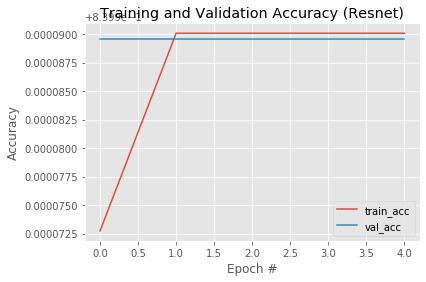

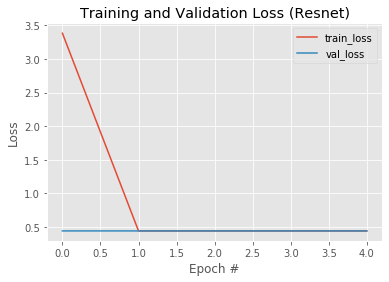

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制结果曲线

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy (Resnet)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_acc.png')
 
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss (Resnet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_loss.png')

# 4 计算结果

In [25]:
# 恢复数据
with open(f'{base_path}/temp/test.txt', 'rb') as f:
    test = pickle.load(f)

## 4.1 LGBM结果

In [26]:
sub['label'] = model_lgb.predict_proba(test[feature_cols])[:, 1]

In [27]:
sub.to_csv('./storage/result.txt', index=None, header=None, sep='\t')

## 4.2 神经网络结果

In [37]:
res = model.predict(test[feature_cols], batch_size=BATCH_SIZE)
res

array([[0.51117074],
       [0.51117074],
       [0.51117074],
       ...,
       [0.5111708 ],
       [0.5111708 ],
       [0.5111708 ]], dtype=float32)

In [87]:
test[feature_cols]

,freq,freq_count,gender,gender_count,hour,q_ans_count,q_diff_qa_days_max,q_diff_qa_days_mean,q_diff_qa_days_sum,q_has_img_max,...,uf_c2_count,uf_c3,uf_c3_count,uf_c4,uf_c4_count,uf_c5,uf_c5_count,uid_enc,uid_enc_count,wk
0,6,0.325453,4,0.0000,9,NaN,NaN,NaN,NaN,NaN,...,0.439214,203,0.479449,1376,0.000038,3,0.346068,1752473,0.000000,6
1,2,0.726702,4,0.0000,22,NaN,NaN,NaN,NaN,NaN,...,0.439214,396,0.456703,521,0.008534,3,0.346068,767938,0.000000,1
2,6,0.325453,2,0.4874,15,NaN,NaN,NaN,NaN,NaN,...,0.439214,205,0.083870,445,0.007599,3,0.346068,1147981,0.000009,3
3,5,1.000000,3,1.0000,4,4.0,11.0,3.0,12.0,0.0,...,0.439214,188,0.114102,1038,0.001950,2,1.000000,1372679,0.000015,2
4,6,0.325453,2,0.4874,19,NaN,NaN,NaN,NaN,NaN,...,0.168475,336,0.137013,788,0.001688,3,0.346068,1,0.297591,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141678,6,0.325453,4,0.0000,20,NaN,NaN,NaN,NaN,NaN,...,0.168475,81,0.020067,760,0.434533,3,0.346068,504330,0.000000,5
1141679,3,0.118357,4,0.0000,21,NaN,NaN,NaN,NaN,NaN,...,0.439214,121,0.094249,760,0.434533,3,0.346068,1066119,0.000003,1
1141680,2,0.726702,4,0.0000,15,NaN,NaN,NaN,NaN,NaN,...,0.001308,313,0.056923,760,0.434533,3,0.346068,435862,0.000000,0
1141681,6,0.325453,4,0.0000,8,NaN,NaN,NaN,NaN,NaN,...,0.439214,8,0.442846,1375,0.031122,3,0.346068,1287652,0.000015,0
